You are a Data Analyst at a travel research firm tasked with analyzing Airbnb activity in Asheville, NC. Your goal is to evaluate pricing, demand, and host activity trends to help a travel startup decide whether whether to expand services in Asheville.

Your manager says:

“We’re exploring Asheville as a target market. Can you analyze this Airbnb data and tell me:

1. What pricing trends look like?

2. Which neighborhoods and hosts are most active?

3. What review activity says about demand?”


Here’s what you should do:
1. **Data Preparation**

    - Inspect each dataset and check for missing values (e.g., neighbourhood_group is blank).

    - Look for outliers in price (e.g., very low or very high nightly rates).

    - Merge reviews.csv with listings.csv to connect review activity to listing details.

2. **Descriptive Analysis**

    - Calculate the average and median nightly price for all listings.

    - Show the distribution of room types (Entire home, Private room, Shared room).

    - Count the number of active listings per neighborhood.

3. **Pricing Insights**

    - Compare average price by neighborhood (use neighbourhood field).

    - Identify the top 5 most expensive neighborhoods.

    - Check if minimum nights affect average price.

4. **Review & Demand Analysis**

    - Calculate the total number of reviews per listing and the average reviews per month.
    
    - Identify which neighborhoods generate the most guest activity.
    
    - Look at trends in reviews.csv → which years/months had spikes in demand?

5. **Host Analysis**

    - Find the hosts with the most listings (calculated_host_listings_count).
    
    - Compare Superhosts vs. non-Superhosts (if data available).
    
    - Check whether hosts with multiple listings charge higher or lower average prices.

6. **Recommendations**

    - Based on the data, suggest whether Asheville is a good expansion market.
    
    - Highlight specific neighborhoods or property types with strong opportunity.
    
    - Point out risks (e.g., heavy reliance on a few hosts, seasonal demand). to expand services in Asheville.



# 1. Data Preparation

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [2]:
# load the listings data
listings = pd.read_csv("listings.csv")

listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.578640,-82.595780,Entire home/apt,95.0,1,454,2025-06-14,2.69,8,162,16,NaN
1,197263,Tranquil Room & Private Bath,961396,Timothy,NaN,28806,35.577350,-82.638040,Private room,44.0,2,87,2024-09-08,0.56,2,73,5,NaN
2,209068,Terrace Cottage,1029919,Kevin,NaN,28804,35.617641,-82.551819,Entire home/apt,90.0,30,67,2025-05-03,0.40,1,268,2,NaN
3,246315,Asheville Dreamer's Cabin,1292070,Annie,NaN,28805,35.596150,-82.506350,Private room,61.0,7,53,2019-10-30,0.32,3,62,0,NaN
4,314540,Asheville Urban Farmhouse Entire Home 4.6 mi t...,381660,Tom,NaN,28806,35.585610,-82.627310,Entire home/apt,200.0,1,35,2025-06-13,0.22,1,139,11,NaN


In [3]:
# check the shape
listings.shape

(2876, 18)

The dataset contains 2876 rows and 18 columns

In [4]:
# check the dtypes and null
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2876 entries, 0 to 2875
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              2876 non-null   int64  
 1   name                            2876 non-null   object 
 2   host_id                         2876 non-null   int64  
 3   host_name                       2876 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   2876 non-null   int64  
 6   latitude                        2876 non-null   float64
 7   longitude                       2876 non-null   float64
 8   room_type                       2876 non-null   object 
 9   price                           2536 non-null   float64
 10  minimum_nights                  2876 non-null   int64  
 11  number_of_reviews               2876 non-null   int64  
 12  last_review                     26

Two main issues arise from the information above
1. Missing values in `price`, `last_review`, `reviews_per_month`
2. Datatype mismatch for the last_review column. Appears as object instead of datetime

In [5]:
# Converting the last_review columns to data_time 

listings["last_review"] = pd.to_datetime(listings["last_review"])

# check the dtypes to confirm the changes
listings.dtypes

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                      float64
neighbourhood                              int64
latitude                                 float64
longitude                                float64
room_type                                 object
price                                    float64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
number_of_reviews_ltm                      int64
license                                  float64
dtype: object

In [6]:
# Check for the span of the last_review date. We need recent data to guide decison_making

earliest_last_review = listings["last_review"].min()
latest_last_review = listings["last_review"].max()

print(f"Earliest last review: {earliest_last_review}")
print(f"Latest last review: {latest_last_review}")


Earliest last review: 2015-10-03 00:00:00
Latest last review: 2025-06-16 00:00:00


In [7]:
# filter for data from 2021 and keep listings without any reviews since they may be new listings which are not yet reviewed
recent_listings = listings.query("last_review >= '2021-01-01' or last_review.isna()").copy()

# confirm the success of the filtering
recent_listings["last_review"].min(), recent_listings["last_review"].max()

(Timestamp('2021-02-14 00:00:00'), Timestamp('2025-06-16 00:00:00'))

Although the `last_review` date spans from 2015 to 2025, for this analysis, the focus will be on data from 2021 onwards, which reflects the most recent and stable market conditions following the COVID 19 pandemic. Properties with no reviews for years may be inactive, delisted, or irrelevant to current market conditions, hence the exclusion of `last_review` date below 2021. Listings with `NaT` last_reviews were maintained because they may likely represent new unreviewed listings

In [8]:
# Check the shape of our working recent listings data
recent_listings.shape

(2852, 18)

In [9]:
# Drop possible duplicates though none is expeted
recent_listings = recent_listings.drop_duplicates()
recent_listings.shape

(2852, 18)

Comparing our filtered `recent_listings` dataset to the orignal `listings` dataset shows that 24 records were filtered out (had last-review < 2015).
`listings` had 2876 rows and `recent_listings` has 2852 rows. We did not lose much data from filtering.

In [10]:
# finding columns that contain  null values
missing_n = recent_listings.isna().sum()
missing_n[missing_n > 0]

neighbourhood_group    2852
price                   334
last_review             263
reviews_per_month       263
license                2852
dtype: int64

In [11]:
# Proportion of the columns that contain null values
missing_pct = recent_listings.isna().mean()
missing_pct[missing_pct > 0]

neighbourhood_group    1.000000
price                  0.117111
last_review            0.092216
reviews_per_month      0.092216
license                1.000000
dtype: float64

`neighbourhood_group` and `license` columns are entirely null.

Close to 12% of the `price` values are missing. About 9% of the `last_review` and `reviews_per_month` data are missing. These are likely new and unreviewed listings.

In [12]:
# Drop the neighbourhood_group and license columns since all the values are null
recent_listings.dropna(how = "all", 
               axis = 1, 
               inplace = True)

In [13]:
# View the columns to confirm the dropping of the groups
recent_listings.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm'],
      dtype='object')

In [14]:
# Filln the missing price values with the median price
median_price = recent_listings["price"].median()
recent_listings["price"] = recent_listings["price"].fillna(median_price)

In [15]:
# Check for null to confirm the imputation
recent_listings.isna().sum()

id                                  0
name                                0
host_id                             0
host_name                           0
neighbourhood                       0
latitude                            0
longitude                           0
room_type                           0
price                               0
minimum_nights                      0
number_of_reviews                   0
last_review                       263
reviews_per_month                 263
calculated_host_listings_count      0
availability_365                    0
number_of_reviews_ltm               0
dtype: int64

# 2. Descriptive Analysis

With the data initially cleaned and prepared, I proceeded with some descriptive statistics. Further cleaning such as handling of outliers was done.

In [16]:
# Check the summary statistics of the other numeric features of the listings
cols_of_interest = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month",
                     "calculated_host_listings_count", "availability_365", "number_of_reviews_ltm"]
recent_listings[cols_of_interest].describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2852.000000,2852.000000,2852.000000,2589.000000,2852.000000,2852.000000,2852.000000
mean,174.622370,5.789972,111.282258,2.185129,9.133240,224.873422,13.864656
std,207.996744,17.789635,154.858791,1.993351,21.953854,116.930660,18.331697
min,18.000000,1.000000,0.000000,0.020000,1.000000,0.000000,0.000000
25%,95.000000,1.000000,10.000000,0.690000,1.000000,137.000000,1.000000
50%,128.000000,2.000000,53.000000,1.640000,2.000000,254.000000,7.000000
75%,190.000000,2.000000,145.000000,3.090000,4.000000,331.000000,20.000000
max,6846.000000,730.000000,1448.000000,19.960000,108.000000,365.000000,186.000000


In [17]:
# Check skew and kurtosis as a dataframe
pd.DataFrame({"Skew" : recent_listings[cols_of_interest].skew(),
              "Kurtosis" : recent_listings[cols_of_interest].kurt()}
            )

,Skew,Kurtosis
price,14.232437,386.940286
minimum_nights,25.076903,971.442408
number_of_reviews,2.572428,9.161728
reviews_per_month,1.693370,4.830100
calculated_host_listings_count,3.645585,12.984598
availability_365,-0.556923,-0.989764
number_of_reviews_ltm,2.467405,9.605100


The summary statistics reveal outliers in `price`, `minimum_night` and `number_of_reviews_ltm`. These columns have maximum values which are practically unrealistic and needs to be dealt with lest they affect the analysis. `price` and `minimum_night` are highly postively skewed (large skew values) and with a lot of outliers (large kurtosis).

**Outlier handling strategy**

The plan is to get the 1st and 99th percentiles as the minimum and maximum values and replace all outliers above the 99th percentile with the 99th percentile value and those below the 1st percentile with the 1st percentile value. `number_of_reviews` is an integer column and so was cast as `int`.

In [18]:
# Dealing with outliers

for col in cols_of_interest:
    lower_val, upper_val = listings[col].quantile([0.01, 0.99])
    
    if col == "number_of_reviews":
        upper_val = int(upper_val)

    recent_listings[col] = recent_listings[col].clip(lower = lower_val, upper = upper_val)

In [19]:
# Check for the effects of the changes
recent_listings[cols_of_interest].describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2852.000000,2852.000000,2852.000000,2589.000000,2852.000000,2852.000000,2852.000000
mean,169.344057,5.134993,109.721950,2.168168,9.133240,224.873422,13.645161
std,141.146151,8.963409,146.645946,1.914680,21.953854,116.930660,17.184220
min,37.000000,1.000000,0.000000,0.050000,1.000000,0.000000,0.000000
25%,95.000000,1.000000,10.000000,0.690000,1.000000,137.000000,1.000000
50%,128.000000,2.000000,53.000000,1.640000,2.000000,254.000000,7.000000
75%,190.000000,2.000000,145.000000,3.090000,4.000000,331.000000,20.000000
max,998.650000,30.000000,741.000000,8.724000,108.000000,365.000000,82.000000


In [20]:
# Add the skew and kurtosis as a dataframe
pd.DataFrame({"Skew" : recent_listings[cols_of_interest].skew(),
              "Kurtosis" : recent_listings[cols_of_interest].kurt()}
            )

,Skew,Kurtosis
price,3.311490,13.985509
minimum_nights,2.307816,3.459402
number_of_reviews,2.091938,4.627469
reviews_per_month,1.296521,1.419544
calculated_host_listings_count,3.645585,12.984598
availability_365,-0.556923,-0.989764
number_of_reviews_ltm,1.837766,3.445485


There is a significant improvement in the skews and kurtosis after handling the outliers. Also the `price`, `number_of_reviews` and `number_of_reviews_ltm` now have their maximum values capped to their 99th percentiles.

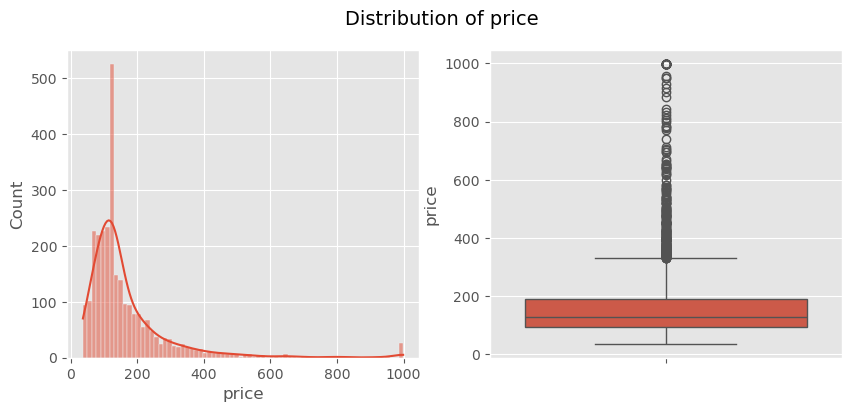

In [21]:
# visualising the review_per_month distribution
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ax.flatten()
sns.histplot(x = recent_listings["price"], ax = ax[0], kde = True)

sns.boxplot(y = recent_listings["price"], ax = ax[1])

fig.suptitle("Distribution of price", fontsize = 14)
plt.show()

The prevailing analysis and visualisations on the price column reveals that the price distribution is rightly-skewed with some outliers (skew = 3.3 and kurtosis = 14). Most of the listings are relatively affordable ( median = $128). However there are some expensive listings too which may possibly be luxury or premium apartments which is normal in this case.

The average and median price for all listings are `$169.00` and `$127.00` respectively.

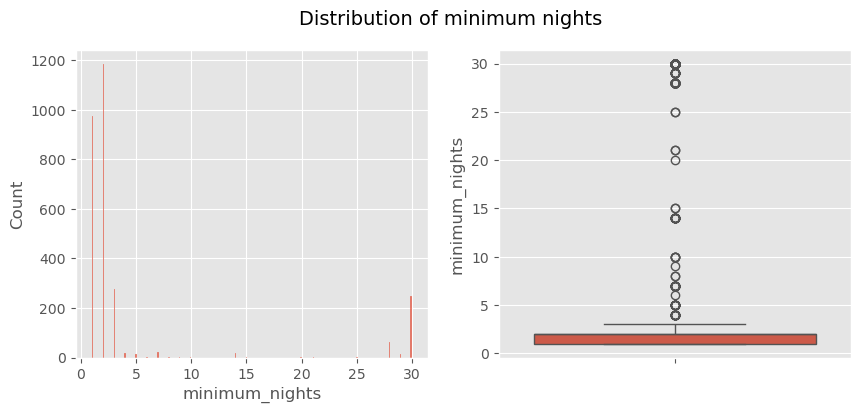

In [22]:
# visualising the minimum_nights distribution
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ax.flatten()
sns.histplot(x = recent_listings["minimum_nights"], ax = ax[0])

sns.boxplot(y = recent_listings["minimum_nights"], ax = ax[1])

fig.suptitle("Distribution of minimum nights", fontsize = 14)
plt.show()

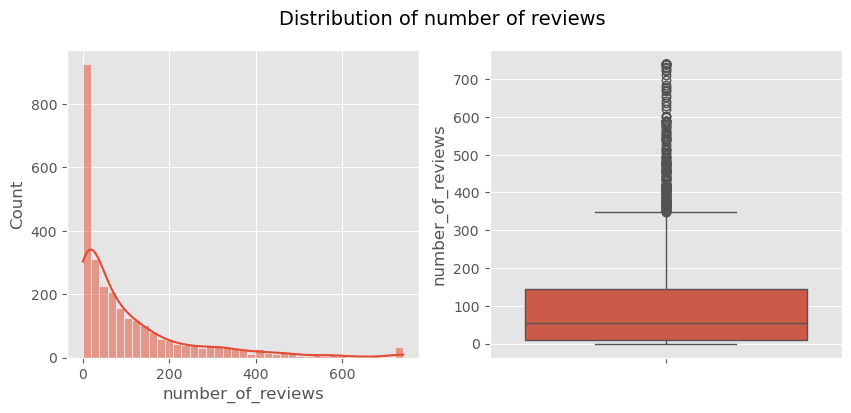

In [23]:
# visualising the number of reviews distribution
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ax.flatten()
sns.histplot(x = recent_listings["number_of_reviews"], ax = ax[0], kde = True)

sns.boxplot(y = recent_listings["number_of_reviews"], ax = ax[1])

fig.suptitle("Distribution of number of reviews", fontsize = 14)
plt.show()

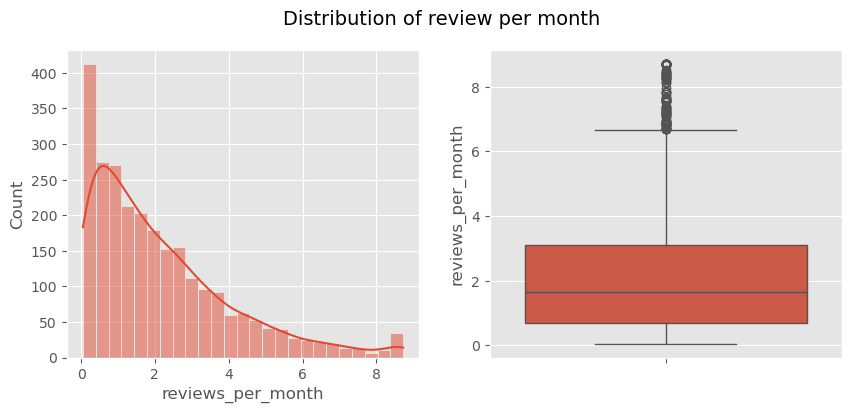

In [24]:
# visualising the review_per_month distribution
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ax.flatten()

sns.histplot(x = recent_listings["reviews_per_month"], ax = ax[0], kde = True)

sns.boxplot(y = recent_listings["reviews_per_month"], ax = ax[1])

fig.suptitle("Distribution of review per month", fontsize = 14)
plt.show()

The analysis and visualisations on the `review_per_month` and `number_of_reviews` columns shows that their distribution is right-skewed. The median number of reviews is 53 with an average of 110  reviews. For `review_per_month`, most of the values lie below 2 reviews per month (median = 1.64).

This means that the majority of Airbnb listings in Asheville receive a low to moderate number of reviews each month, while a smaller number of highly popular listings get significantly more reviews, pulling the average upward  (2.17).

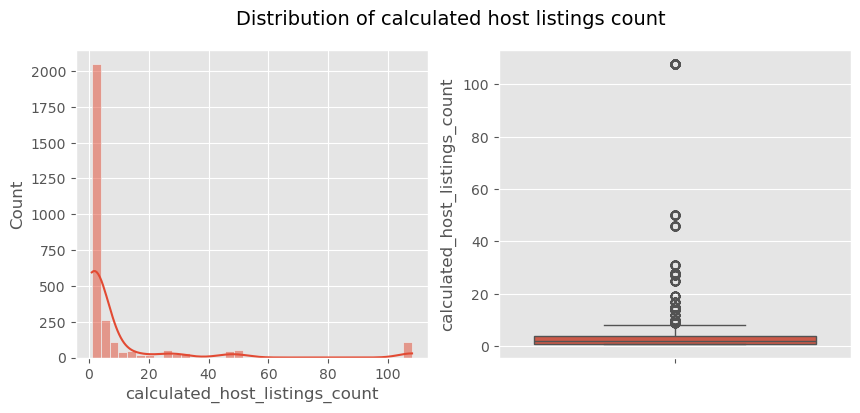

In [25]:
# visualising the number of calculated host_listings distribution
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ax.flatten()

sns.histplot(x = recent_listings["calculated_host_listings_count"], ax = ax[0], binwidth = 3, kde = True)

sns.boxplot(y = recent_listings["calculated_host_listings_count"], ax = ax[1])

fig.suptitle("Distribution of calculated host listings count", fontsize = 14)
plt.show()

The distribution of the `calculated_host_listings_count` shows that most of the hosts have less than 3 listings (median = 2) with a few hosts having more than 10 listings. One host has more than 100 listings!

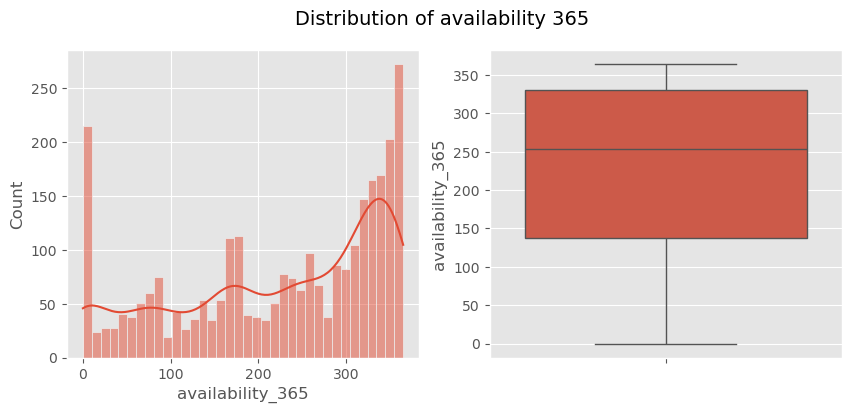

In [26]:
# visualising the number of reviews distribution
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ax.flatten()

sns.histplot(x = recent_listings["availability_365"], ax = ax[0], binwidth = 10, kde = True)

sns.boxplot(y = recent_listings["availability_365"], ax = ax[1])

fig.suptitle("Distribution of availability 365", fontsize = 14)
plt.show()

The distribution of the `availability_365` shows a slighly negatively-skewed distribution. The median availabilty is 254 days and an average of 224 days. This means that most listings are available for booking for most part of the year. At the extreme left it shows a good number of listings have a small `availability_365`

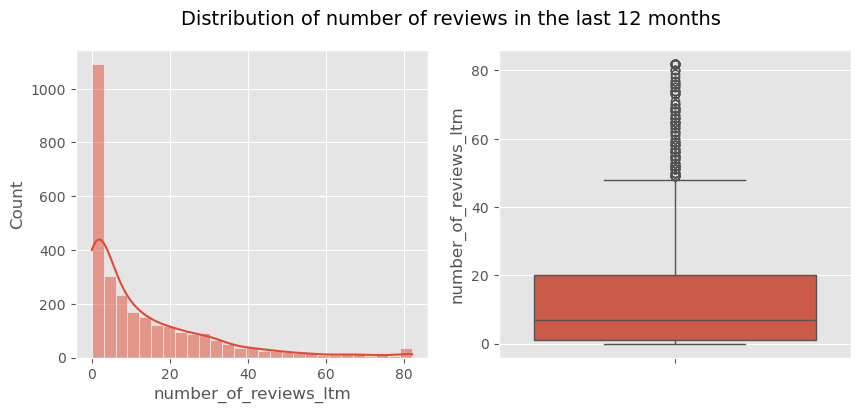

In [27]:
# visualising the number of reviews tm distribution
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ax.flatten()

sns.histplot(x = recent_listings["number_of_reviews_ltm"], ax = ax[0], binwidth = 3, kde = True)

sns.boxplot(y = recent_listings["number_of_reviews_ltm"], ax = ax[1])

fig.suptitle("Distribution of number of reviews in the last 12 months", fontsize = 14)
plt.show()

The distribution of the number of reviews in the last 12 month also shows a positively skwed distribution. The median is 7 with am average of 12.This means while most listings got under 8 reviews in the last 12 months, few popular ones have received a lot of reviews in the last 12 months therby driving the mean upwards.

### Different types of rooms listed and their proprtions

In [28]:
# Get the different types of room and their countd
recent_listings["room_type"].value_counts()

room_type
Entire home/apt    2551
Private room        281
Hotel room           12
Shared room           8
Name: count, dtype: int64

In [29]:
# Find the different types of rooms listed and their proprtions
recent_listings["room_type"].value_counts(normalize=True) * 100

room_type
Entire home/apt    89.446003
Private room        9.852735
Hotel room          0.420757
Shared room         0.280505
Name: proportion, dtype: float64

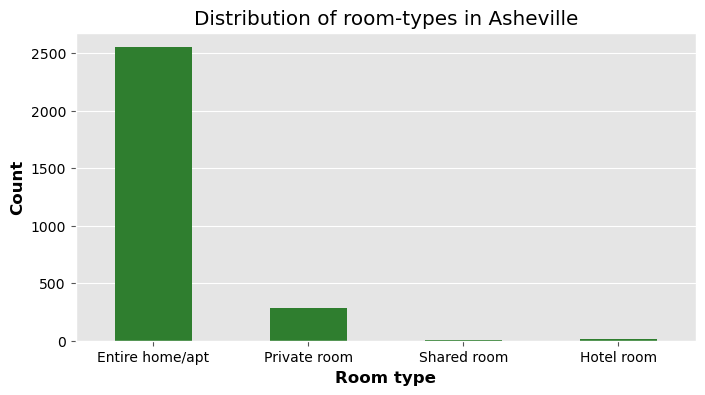

In [30]:
# Show the distribution of room types (Entire home, Private room, Shared room).
fig, ax = plt.subplots(figsize = (8, 4))
sns.countplot(x = recent_listings["room_type"], width = 0.5, color = "forestgreen", ax = ax)
ax.set_title("Distribution of room-types in Asheville")
ax.set_xlabel("Room type", fontweight = "bold", color = "black")
ax.set_ylabel("Count", fontweight = "bold", color = "black")
ax.tick_params(labelcolor = "black")

plt.savefig("images/Distribution of room_types.png", dpi = 300, bbox_inches = "tight")
plt.show()


The analysis reveals that entire home/apartment is the commonest room_type having a count of 2551 with a percentage share of 89%.
Private room has close to 10% share of the room types with a count of 281.

### Number of active listings per neighbourhood

In this analysis active listings can be defined based on 2 assumptions

1. The mere presence of the property in the listings means it is active
2. active listing means availabilty of a room for booking ("availability_365 > 0")

Although the `availability_365` variable indicates how many days a listing is available for booking in the next year, it does not specify why a property has zero available days. A value of 0 may mean that the listing is fully booked (indicating high demand) or blocked by the host (indicating temporary unavailability). Because these two scenarios cannot be distinguished from the dataset alone, excluding listings with zero availability could introduce bias by removing potentially popular or high-performing properties. Therefore, this analysis will includes all listings present in the dataset, representing the complete snapshot of the Asheville Airbnb market at the time of data collection.

In [31]:
# number of active listings per neighbourhood
#  assuming that the mere presence of the property in the listings means it is active
recent_listings.groupby("neighbourhood")["id"].count().sort_values(ascending=False)

neighbourhood
28806    800
28801    588
28803    452
28804    376
28805    281
28704    189
28715     93
28732     73
Name: id, dtype: int64

In [32]:
# assuming active listing means availabilty of a room for booking ("availability_365 > 0")
# neighbourhood_count = (listings
#                        .query("availability_365 > 0")
#                        .groupby("neighbourhood")
#                        .size()
#                        .sort_values(ascending = False)
#                       )
# neighbourhood_count

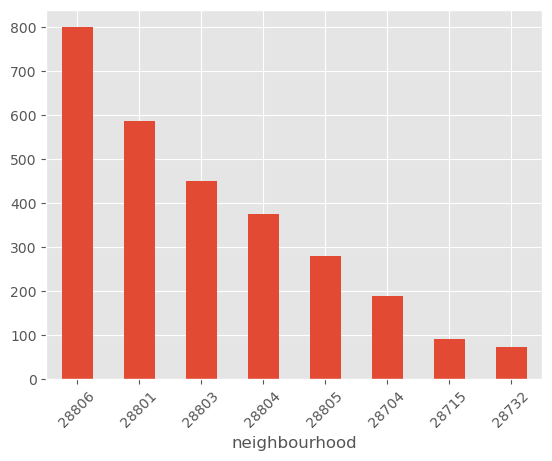

In [33]:
# Count the number of listings in each neighbourhood
recent_listings.groupby("neighbourhood").size().sort_values(ascending=False).plot.bar(rot = 45);

# 3. Price Insights

In [34]:
# Compare average price by neighborhood
round(recent_listings.groupby("neighbourhood")["price"].mean(), 2).sort_values()

neighbourhood
28806    157.97
28715    168.13
28801    170.82
28804    171.59
28805    173.45
28803    174.34
28704    179.93
28732    197.95
Name: price, dtype: float64

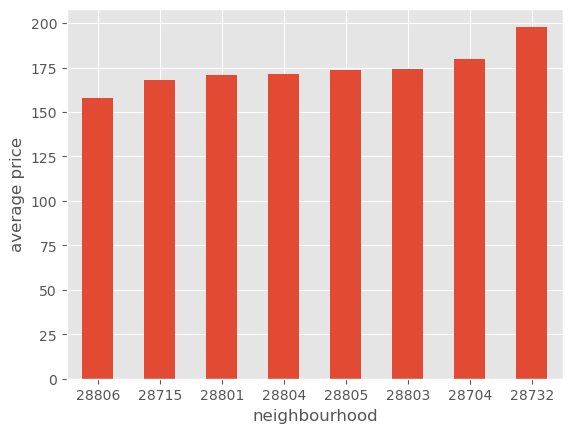

In [35]:
# quick viz of the average price per neighbourhood
round(recent_listings.groupby("neighbourhood")["price"].mean(), 2).sort_values().plot(kind = 'bar', rot = 0, ylabel = "average price");

neighbourhood 28806 has the cheapest listings on average. People tight on budget may first look there.
neighbourhood 28732 has the most expensive average price. This neighbourhood could contain luxurious listings to people with exquisite tastes. It is also obvious that neighbourhood `28806` is highly competitive (with 800 listings) forcing hosts to reduce prices to stay competitive. However, the situation may be different on the ground and so requires further background/field checks.

In [36]:
# Identify the top 5 most expensive neighborhoods.

round(recent_listings.groupby("neighbourhood")["price"].mean(), 2).sort_values(ascending = False)[:5]

neighbourhood
28732    197.95
28704    179.93
28803    174.34
28805    173.45
28804    171.59
Name: price, dtype: float64

above is the top 5 most expensive neighbourhoods

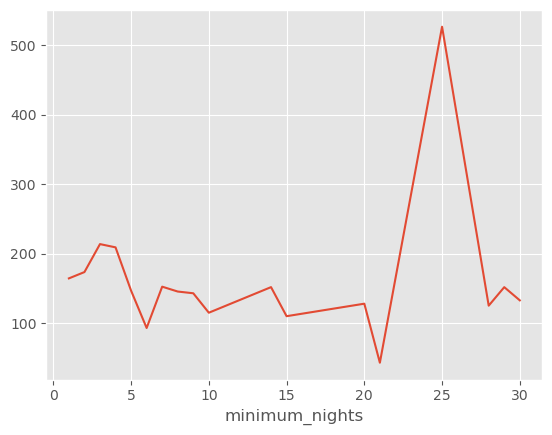

In [37]:
# Check if minimum nights affect average price.
# We do this by plotting a scatter plot of minimum-night against average price

recent_listings.groupby("minimum_nights")["price"].mean().plot();


In [38]:
# Is there a correlation between minimum_night and price
recent_listings[["minimum_nights", "price"]].corr()

,minimum_nights,price
minimum_nights,1.000000,-0.087747
price,-0.087747,1.000000


In [39]:
# averge price per room_type
recent_listings.groupby("room_type")["price"].mean()

room_type
Entire home/apt    177.053156
Hotel room         230.416667
Private room       100.343950
Shared room         43.125000
Name: price, dtype: float64

The analysis and visualisation shows that there is no clear trend between minimum_nights and average price.
There is almost no correlation between `minimum_nights` and `price` although one would ordinarily expect that price should reduce, even slighly as minimum_nights increased

# 4. Review & Demand Analysis
The goal here is to:
- Calculate the total number of reviews per listing and the average reviews per month.

- Identify which neighborhoods generate the most guest activity.

- Look at trends in reviews.csv → which years/months had spikes in demand?

I approached this by merging the the `recent_listings` dataframe with the `reviews` dataframe using  an `inner` join so that only listings with review information was included. This operation automatically filtered out the the recent listings with null `last_review` date since they have have no corresponding data in the `reviews` dataframe.
Then the merged data was filtered for recent review_activities between 2021 and 2024 as `recent_reviews`.

In [40]:
# read the reviews data
reviews = pd.read_csv("reviews.csv")

reviews.head()

,listing_id,date
0,155305,2011-07-31
1,155305,2011-08-23
2,155305,2011-09-19
3,155305,2011-10-28
4,155305,2012-07-01


In [41]:
# Check the shape of the reviews dataframe
reviews.shape

(318549, 2)

In [42]:
# check for datatypes and null
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318549 entries, 0 to 318548
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  318549 non-null  int64 
 1   date        318549 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.9+ MB


There are no missing values in the listings_data set.
However, the date column appeared as `object` type instead of `datetime` type

In [43]:
# Convert the datae column to the datetime type
reviews["date"] = pd.to_datetime(reviews["date"])

# confirm changes
reviews.dtypes

listing_id             int64
date          datetime64[ns]
dtype: object

In [44]:
# Number of unique listings in the reviews dataset
reviews["listing_id"].nunique()

2613

In [45]:
# Check the date span of the reviews
reviews["date"].min(), reviews["date"].max()

(Timestamp('2011-07-31 00:00:00'), Timestamp('2025-06-16 00:00:00'))

The reviews span from 2011 to mid 2025

In [46]:
# Check the number of reviews per each listing in descending order
reviews.groupby("listing_id")["date"].count().sort_values(ascending = False).head()

listing_id
3314819    1448
2411109    1253
2296152    1136
881707     1096
6054250    1052
Name: date, dtype: int64

The next action is to merge the reviews data_set with the listings data sets on id so that we get the full data for when each property was reviewed.


I then then filtered the full data to get recent reviews (from 2021 to 2024) which reflects the most recent and stable market conditions following the COVID 19 pandemic. Recent data is needed to see the current trends of AirBnB to advise and guide the startup. Including older years can affect the analysis since the market might have evolved. 2025 will be excluded since the year has not ended.


In [47]:
# Merge the listings data with reviews before proceeding
# inner join to exclude listed facilities that have never been reviewed
full_data = (recent_listings.rename(columns = {"id" : "listing_id"}) # merge on recent_listings which has last_review date from 2021 filtered
             .merge(reviews.rename(columns = {"date" : "review_date"}), 
                    how = "inner",
                    on = "listing_id")
            )
# full_data.head()

In [48]:
full_data.isna().sum()

listing_id                        0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
review_date                       0
dtype: int64

There are no missing_values because listings with mising `last_review` dates have been filtered out during the inner join operation

In [49]:
# Merge the listings data with reviews before proceeding
recent_reviews = full_data.query("'2021-01-01' <= review_date <= '2024-12-31'").copy() # Filter for recent review activities from 2021 to 2024
            
# recent_reviews.head()

When filtering reviews between 2021–2025, listings without any associated reviews were automatically excluded, as they had no review dates within this range.

In [50]:
# Check the earliest and latest review dates
recent_reviews["review_date"].min(), recent_reviews["review_date"].max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2024-12-31 00:00:00'))

In [51]:
# Check the dtypes again
recent_reviews.dtypes

listing_id                                 int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood                              int64
latitude                                 float64
longitude                                float64
room_type                                 object
price                                    float64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
number_of_reviews_ltm                      int64
review_date                       datetime64[ns]
dtype: object

In [52]:
# Check the shape of the recent_reviews data
recent_reviews.shape

(199259, 17)

`neighbourhood.csv` doesnt seen to contain any useful information.
The entire `neighbourhood_group` is null and the neighbourhood values are all contained in the reviews dataset and so I found no use for it in this analysis.

- Calculate the total number of reviews per listing and the average reviews per month.

- Identify which neighborhoods generate the most guest activity.

- Look at trends in reviews.csv → which years/months had spikes in demand?

### Calculate the total number of reviews per listing and the average reviews per month.


In [53]:
# Calculate the total number of reviews per listing and the average reviews per month.
recent_reviews.groupby("listing_id")["review_date"].count().sort_values(ascending = False)


listing_id
40274759               746
3314819                575
29073142               516
23859316               495
32424479               484
                      ... 
1177581096065801084      1
1297717                  1
1218220756631981065      1
950041853346200508       1
1145864236457678644      1
Name: review_date, Length: 2439, dtype: int64

### Identify which neighborhoods generate the most guest activity.

In [54]:
# Identify which neighborhoods generate the most guest activity.
(recent_reviews
     .groupby("neighbourhood")["review_date"]
     .count()
     .sort_values(ascending = False)
)

neighbourhood
28806    54863
28801    46713
28804    29900
28803    28542
28805    18982
28704    10365
28715     5611
28732     4283
Name: review_date, dtype: int64

neighbourhoods 28806, 28801, 28804, 28803 and 28805 are the top-5 neighbourhoods that generate most guest activity

### Look at trends in reviews.csv → which years/months had spikes in demand?
Here I extracted key date features such as `year`, `month`, `day`, `day_of_week`, `day_name` then I grouped the days into either `weekdays` or `weekends`.

Then I created `period_grouping` function to perform grouping and aggregations based on a date feature passed to it.

In [55]:
# Extracting relevant date features
recent_reviews['review_year'] = recent_reviews["review_date"].dt.year
recent_reviews['review_month'] = recent_reviews["review_date"].dt.month
recent_reviews['review_day'] = recent_reviews["review_date"].dt.day
recent_reviews["review_year_month"] = recent_reviews["review_date"].dt.strftime("%Y-%m")
recent_reviews["day_of_week"] = recent_reviews["review_date"].dt.day_of_week
recent_reviews["day_name"] = recent_reviews["review_date"].dt.strftime("%a")
recent_reviews["weekend"] =  np.where(recent_reviews["day_of_week"] < 5, "Weekday", "Weekend")
# full_data["seasons"] = 

In [56]:
# I created a period_trend function to group the data by specified periods like year, month, day etc

def period_grouping(period, data  = recent_reviews):
    return (data
                .groupby(period)[["listing_id"]]
                .count()
                .reset_index()
                .rename(columns = {"listing_id" : "count"})
               )

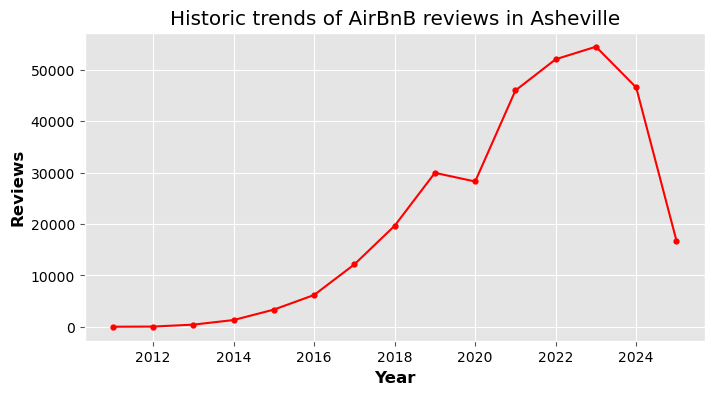

In [57]:
# Visualise the historic trend of demand
historic_trend = (full_data
                  .groupby(full_data.review_date.dt.year)["listing_id"]
                  .count()
                  .reset_index()
                  .rename(columns = {"listing_id" : "count"})
                 )

fig, ax = plt.subplots(figsize = (8, 4))

# plot the data
ax.plot(historic_trend["review_date"], 
        historic_trend['count'], 
        "-or", 
        linewidth = 1.5, 
        markersize = 3.5)
ax.set_title("Historic trends of AirBnB reviews in Asheville")
ax.set_xlabel("Year", fontweight = "bold", color = "black")
ax.set_ylabel("Reviews", fontweight = "bold", color = "black")
ax.tick_params(labelcolor = "black")
plt.savefig("images/Historic trend.png", dpi = 300, bbox_inches = "tight")
plt.show()

C:\Users\AWENARE SUB 1\AppData\Local\Temp\ipykernel_16228\3675062351.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["",2021, "", 2022, "", 2023, "", 2024, ""])


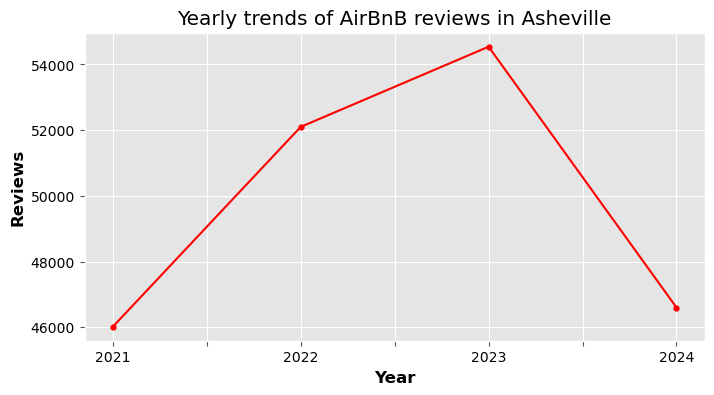

In [58]:
# yearly trends

# get the data
yearly_trend = period_grouping("review_year")

fig, ax = plt.subplots(figsize = (8, 4))

# plot the data
ax.plot(yearly_trend["review_year"], 
        yearly_trend['count'], 
        "-or", 
        linewidth = 1.5, 
        markersize = 3.5)

# customise the plot
ax.set_title("Yearly trends of AirBnB reviews in Asheville")
ax.set_xlabel("Year", fontweight = "bold", color = "black")
ax.set_xticklabels(["",2021, "", 2022, "", 2023, "", 2024, ""])
ax.set_ylabel("Reviews", fontweight = "bold", color = "black")
ax.tick_params(labelcolor = "black")
plt.savefig("images/Recent years trend.png", dpi = 300, bbox_inches = "tight")
plt.show()


Demand begun to rise steadily from 2011 to 2019 and dipped slightly in 2020 probably due to the impact of COVID 19. From 2020, demand has grown every year but saw its all time high in 2023 before dipping in 2024.

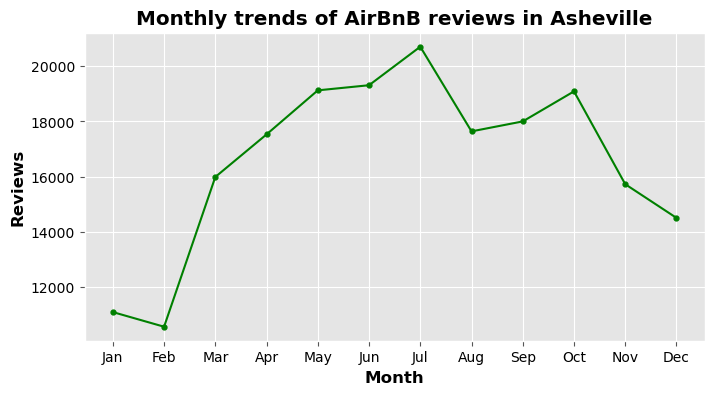

In [59]:
# monthly trends

# get the data
monthly_trend = period_grouping("review_month")

# change the x-tick labels from month numbers to month names
monthly_trend["review_month"] = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# plot the data
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(monthly_trend["review_month"], 
        monthly_trend['count'], 
        "-og", 
        linewidth = 1.5, 
        markersize = 3.5)

# Customise the chart
ax.set_title("Monthly trends of AirBnB reviews in Asheville", fontweight = "bold")
ax.set_xlabel("Month", fontweight = "bold", color = "black")
ax.set_ylabel("Reviews", fontweight = "bold", color = "black")
ax.tick_params(labelcolor = "black")
plt.savefig("images/Monthly_trend.png", dpi = 300, bbox_inches = "tight")
plt.show()

Activities peak in July then decline in November and December (the winter period)

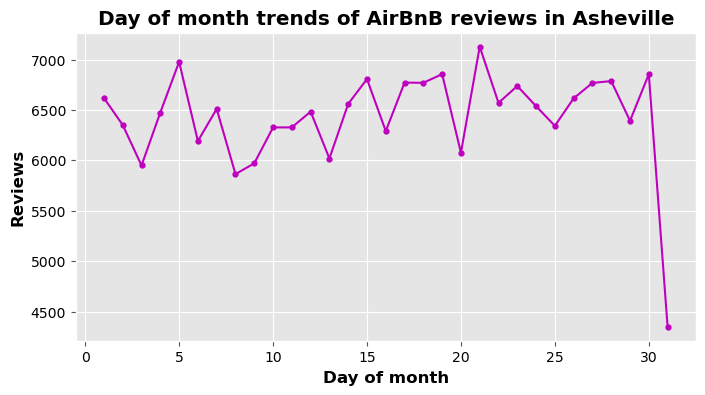

In [60]:
# daily trends

# get the data
daily_trend = period_grouping("review_day")

# plot the data
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(daily_trend["review_day"], 
        daily_trend['count'], 
        "-om", 
        linewidth = 1.5, 
        markersize = 3.5)

# customise the chart
ax.set_title("Day of month trends of AirBnB reviews in Asheville", fontweight = "bold")
ax.set_xlabel("Day of month", fontweight = "bold", color = "black")
ax.set_ylabel("Reviews", fontweight = "bold", color = "black")
ax.tick_params(labelcolor = "black")
plt.show()

Review activities run throughout the days of the month with fluctauations across the days. Day 31 saw the lowest review activities

In [61]:
# Get the trens of name of the days
day_name_trend = period_grouping("day_of_week")

# change the day from day_of_week numbers to abbreviated day_names
day_name_trend["day_of_week"] = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

# calculate the daily shares of the reviews
day_name_trend["%"] = round(day_name_trend['count']/day_name_trend['count'].sum() * 100, 2)

day_name_trend

,day_of_week,count,%
0,Mon,33682,16.90
1,Tues,17314,8.69
2,Wed,17137,8.60
3,Thurs,18796,9.43
4,Fri,22736,11.41
5,Sat,22320,11.20
6,Sun,67274,33.76


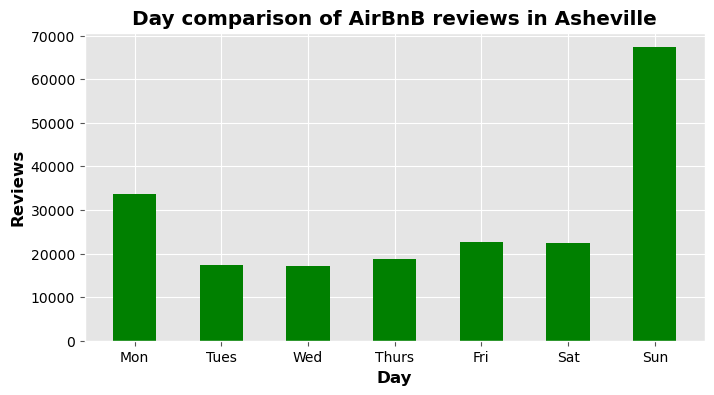

In [62]:
# day_name trend

# plot the data
fig, ax = plt.subplots(figsize = (8, 4))
ax.bar(x = day_name_trend["day_of_week"], 
       height =  day_name_trend['count'],
       width  = 0.5,
      color = "green")

# Customise the chart
ax.set_title("Day comparison of AirBnB reviews in Asheville", fontweight = "bold")
ax.set_xlabel("Day", fontweight = "bold", color = "black")
ax.tick_params(labelcolor = "black")
ax.set_ylabel("Reviews", fontweight = "bold", color = "black")
plt.savefig("images/Day_comparison.png", dpi = 300, bbox_inches = "tight")
plt.show()

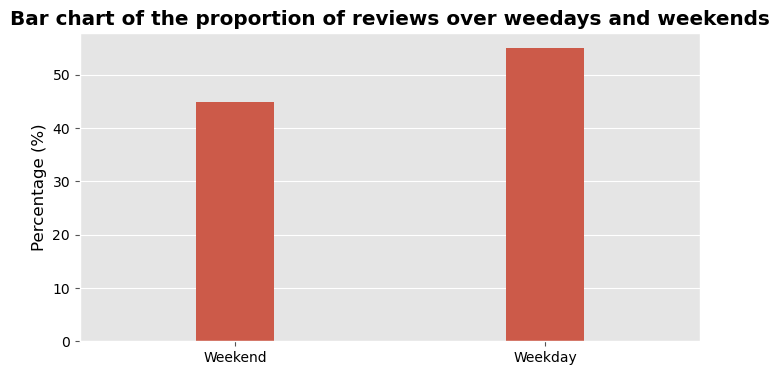

In [63]:
# Weekend-weekday trend
fig, ax = plt.subplots(figsize = (8, 4))

# plot and customise the data
sns.countplot(data = recent_reviews,
             x = "weekend",
             # y = "count",
             width = 0.25,
             stat = "percent",
             ax = ax
            )

ax.set_title("Bar chart of the proportion of reviews over weedays and weekends", fontweight = "bold")
ax.set_xlabel("")
ax.set_ylabel("Percentage (%)", color = "black", size = 12)
ax.tick_params(labelcolor = "black")
plt.show()

Sunday leads as the day with most demand/activites with close to 67274 reviews representing  a little over one-third (33.8%) of all reviews. There is a spike in activities/demand follwoing relatively calm days from Tuesdays to Saturdays.
The next busiest day is Monday with reviews of 53631	(16.9%). 

The least busiest days are Wednesdays and Tuesdays (28532, 8.96%) and  Wednesdays (28031, 8.8%).

Weekdays see more activities (55%) than weekends (45%) whose activities are mainly done on Sundays.

# 5. Host Analysis

- Find the hosts with the most listings (calculated_host_listings_count).

- Compare Superhosts vs. non-Superhosts (if data available).

- Check whether hosts with multiple listings charge higher or lower average prices.

For this analysis, I used the `recent_listings` dataframe since it does not have duplicated data.


### Find the hosts with the most listings (calculated_host_listings_count).


In [64]:
# - Find the hosts with the most listings (calculated_host_listings_count).
top_hosts = (recent_listings
                 .groupby(["host_id", "host_name"])["id"]
                 .nunique().sort_values(ascending = False)[:10]
            )
top_hosts

host_id    host_name                       
167186184  Towns                               108
96187307   Yonder                               50
134903005  Carolina Mornings                    46
121681645  Evolve                               31
242474849  Jennifer                             28
480217041  AvantStay                            27
581734305  Asheville Cabins Of Willow Winds     25
151279507  Amanda Elizabeth                     19
46001530   Jonathan                             17
250328755  River Row Flats, Inc                 15
Name: id, dtype: int64

**Compare Superhosts vs. non-Superhosts (if data available).**

There is no data avaliable for this analysis

### Check whether hosts with multiple listings charge higher or lower average prices.

Hosts with multiple listings are those with > 1 `calcuated_host_listings`. I filtered the recent_listings dataframe for `calcuated_host_listings` > 1, grouped by same `calcuated_host_listings` found the average price for each count. The data was then visualised with a line chart to see how average price changes with the listing_count.


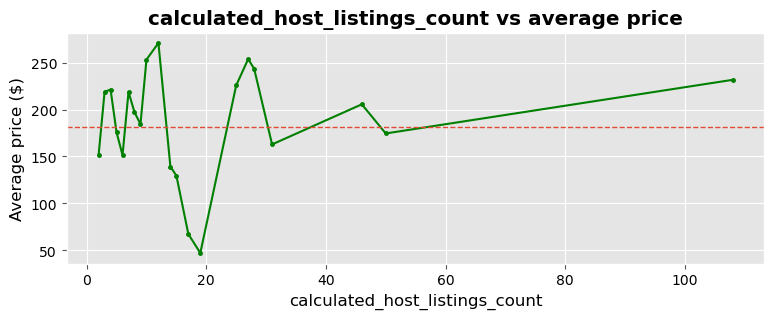

In [65]:
# - Check whether hosts with multiple listings charge higher or lower average prices.

multiple_listed_hosts = (recent_listings
                         .query("calculated_host_listings_count > 1")
                         .groupby("calculated_host_listings_count")["price"]
                         .mean()
                        )
# Visualise calculated_host_listings_count vr average price

fig, ax = plt.subplots(figsize = (9, 3))
ax.plot(multiple_listed_hosts.index, multiple_listed_hosts, "-go", linewidth = 1.5, ms = 2.5)
ax.axhline(listings["price"].mean(), lw = 1.0, ls = "--")
ax.set_title("calculated_host_listings_count vs average price", fontweight = "bold")
ax.set_xlabel("calculated_host_listings_count", color = "black")
ax.set_ylabel("Average price ($)", color = "black", size = 12)
ax.tick_params(labelcolor = "black")
plt.show()

In [66]:
# Average price for hosts with 1 listings
recent_listings.loc[recent_listings["calculated_host_listings_count"] == 1, "price"].mean()

152.05139385275197

The analysis shows that except for a few cases, hosts with multiple listings charge higher average prices than hosts with only 1 listing.
Moreover, most of the hosts with multiple listings charge higher than the overall average price.

In [67]:
# Check for reliance on hosts by counting the number of reviews for each host
host_review_agg = (recent_reviews
                    .groupby("host_id")
                    .agg(number_of_listings = ("listing_id", "nunique"),
                        number_of_reviews = ("review_date", "count"))
                    .sort_values(by = "number_of_listings", ascending = False)
                 )
# add the pct reviews and listings per host
host_review_agg["pct_review"] = host_review_agg["number_of_reviews"] / len(full_data) * 100
host_review_agg["pct_listing"] = host_review_agg["number_of_listings"] / sum(host_review_agg["number_of_listings"]) * 100
host_review_agg.head(10)


,number_of_listings,number_of_reviews,pct_review,pct_listing
host_id,,,,
167186184,104,7142,2.250321,4.264043
96187307,44,957,0.301534,1.804018
134903005,41,782,0.246395,1.681017
480217041,27,781,0.246080,1.107011
121681645,27,803,0.253011,1.107011
242474849,25,2351,0.740759,1.025010
151279507,18,724,0.228120,0.738007
250328755,15,1198,0.377469,0.615006
10603047,11,64,0.020165,0.451005


### Checking where newer/unreviewed listings are located

As explained earlier, listings with null last_review may likely be new listings which are yet to be reviewed. I analysed this subset of data to find out where newer listings are located. 

In [68]:
# filter the recent_listings data for unreviewed listings
unreviewed_listings = recent_listings.query("last_review.isna()")

In [69]:
# Check the shape 
unreviewed_listings.shape

(263, 16)

In [70]:
# group by neighbourhood and sort to know the top neighbourhoods by number of listings
unreviewed_listings.groupby("neighbourhood")["id"].count().sort_values(ascending = False)

neighbourhood
28806    77
28803    56
28801    52
28805    26
28804    23
28704    12
28715    11
28732     6
Name: id, dtype: int64

neighbourhood `28806`, `28803` and `28800` dominates among newer unreviewed listings

In [71]:
# Which hosts and where are listing new facilities
unreviewed_listings.groupby(["host_id", "neighbourhood"])["id"].count().sort_values(ascending = False)

host_id    neighbourhood
581734305  28803            13
665399107  28801            10
25138314   28806             8
443140321  28801             4
674785574  28805             3
                            ..
47498677   28801             1
50327008   28806             1
52253417   28803             1
52671957   28715             1
681769558  28805             1
Name: id, Length: 211, dtype: int64

# 6. Recommendations

**1. Based on the data, suggest whether Asheville is a good expansion market.**

Per the data Ashevile is a good expansion market, there are few companies with listings > 20. Although `Towns` with host_id `167186184` dominate the market with 104 listings, that is about 4.3% of the total listings and get 2.3% of the reviews from 2021 to 2024. Majority of the hosts have only 1 lisitings and such hosts are likely to be individuals.

**2. Highlight specific neighborhoods or property types with strong opportunity.**

Property type with strong opportunities are `Entire home/Apt` which has a market share of over 89%.
Neighbourhood `28806` dominate with 800 listings followed by `28801` with  588 listings and `28803` with 452 listings. These neighbourhoods can be considered since they are the hotspots in the market.

**3. Point out risks (e.g., heavy reliance on a few hosts, seasonal demand).**

There is no heavy reliance on a few host because the biggest host `167186184` has a share of 4.3% of all the listings and has the highest number of reviews which constitute about 2% of all reviews. Even though there are lot of listings, there are no dominant market leaders and so business in Asheville appears promising with the right strategies in place.

However, the top 3 neighbourhoods with most listings must be well researched and so more field studies/research must be carried out to know why they dominate with the aim of improving user experience and compete well. Indeed, further analysis of newer/unreviewed listings reveals that new listings are springing up in neighbourhoods `28803`, `28801` and `28806`.

Seasonal demand: The market dips during the winter periods which is normal. It is however active on all days of the month except month-day 31.

Sundays is the most active review day taking over 1/3 of the reviews. This means that a lot of users are active on the AirBnB app on Sundays posting reviews and looking for listings. That is a good day to run follow-up, reviews and referral offers. It also suggests that most checkouts occur during the weekends and that bookings may be high from Wednesday towards Saturday. Marketing campaings can be intensified from midweek towards the weekend.
